# Lab 2 Data Visualisation on Python with Matplotlib

## 1. Data Import

In [1]:
import pandas as pd
from tqdm.notebook import tqdm

import random
import matplotlib.pyplot as plt
import re
import multiprocessing
#!pip install deep_translator
from deep_translator import GoogleTranslator

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

translator = GoogleTranslator(source='auto', target='en')

df = pd.read_csv('lab2.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudinigor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Draw a bar graph by the number of missing values in each field of the loaded data. Pre-sort the frequencies in descending order.
2.1 Add data according to the number of unique values in each field

2.2 Replace background of chart with grey ('#E6E6E6')

2.3 Replaced the gap width between columns with

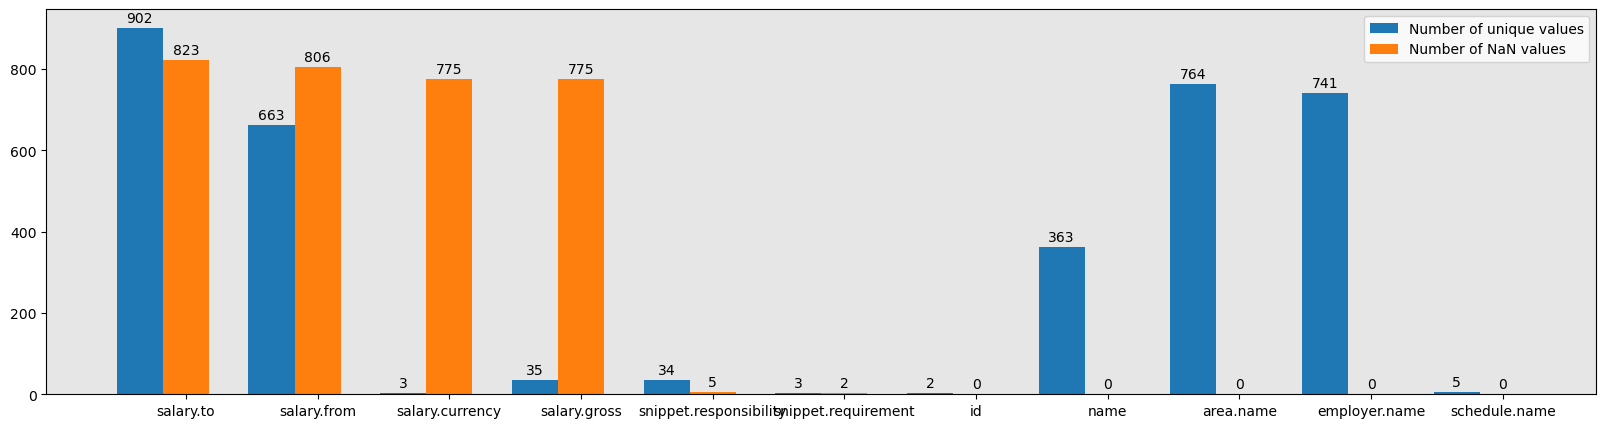

In [2]:
plt.figure(figsize=(20, 5))
ax = plt.axes()
x = range(len(df.columns))
width = 0.35
multiplier = 0
for data, name in zip([df.nunique(), df.isna().sum().sort_values(ascending=False)], ['Number of unique values', 'Number of NaN values']):
    bar = ax.bar([i + width * multiplier for i in x], data, width=width, label=name)
    ax.bar_label(bar, padding=2)
    multiplier += 1
ax.set_facecolor('#E6E6E6')
ax.legend()
ax.set_xticks([i + width for i in x], data.index)
plt.show();


## 3. Create a bar chart by the number of anomalous values (too big,too small, by value, by number of characters) for the fields salary.from, salary.to, snippet.requirement, snippet.responsibility

3.1 Apply "ggplot" style to the chart.

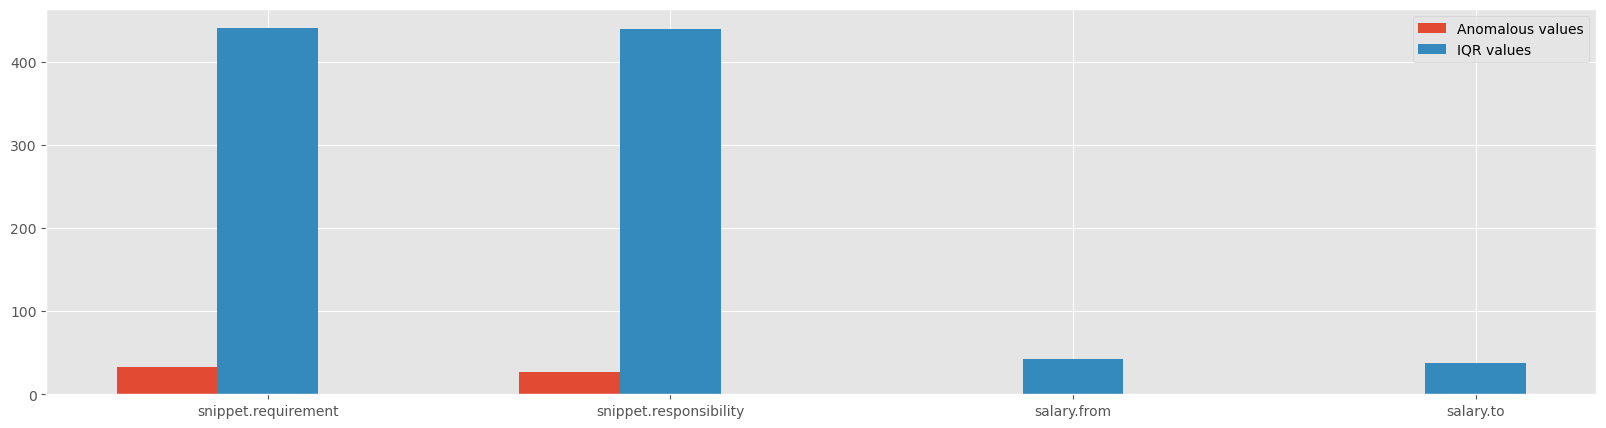

In [3]:
data_anomalous = {}
data_IQR = {}
text_columns = ["snippet.requirement", "snippet.responsibility"]
numerical_columns = ["salary.from", "salary.to"]
anomalous_condition = lambda x: (x < quartile_1 - 1.5 * (quartile_3 - quartile_1)) | (x > quartile_3 + 1.5 * (quartile_3 - quartile_1))
IQR_condition = lambda x: (x < quartile_1) | (x > quartile_3)

for text_column in text_columns:
    sliced_df = df[text_column].str.len()
    quartile_1 = sliced_df.quantile(0.25)
    quartile_3 = sliced_df.quantile(0.75)
    data_anomalous[text_column] = len(sliced_df[anomalous_condition(sliced_df)])
    data_IQR[text_column] = len(sliced_df[IQR_condition(sliced_df)])

for numerical_column in numerical_columns:
    sliced_df = df[numerical_column]
    quartile_1 = sliced_df.quantile(0.25)
    quartile_3 = sliced_df.quantile(0.75)
    data_anomalous[numerical_column] = len(sliced_df[anomalous_condition(sliced_df)])
    data_IQR[numerical_column] = len(sliced_df[IQR_condition(sliced_df)])
    
with plt.style.context('ggplot'):
    plt.figure(figsize=(20, 5))
    x = range(len(data_anomalous))
    width = 0.25
    plt.bar(x, data_anomalous.values(), width=width, label='Anomalous values')
    plt.bar([i + width for i in x], data_IQR.values(), width=width, label='IQR values')
    plt.xticks([i + width for i in x], data_anomalous.keys())
    plt.legend()
    

## 4. Create a pie chart of the number of jobs in the cities using area.name field.

4.1.Add name of chart, caption wedges with name of cities, percentage, absolute value.

4.2 Make the wedge with the highest frequency stand out (use the scatter parameter - explode).

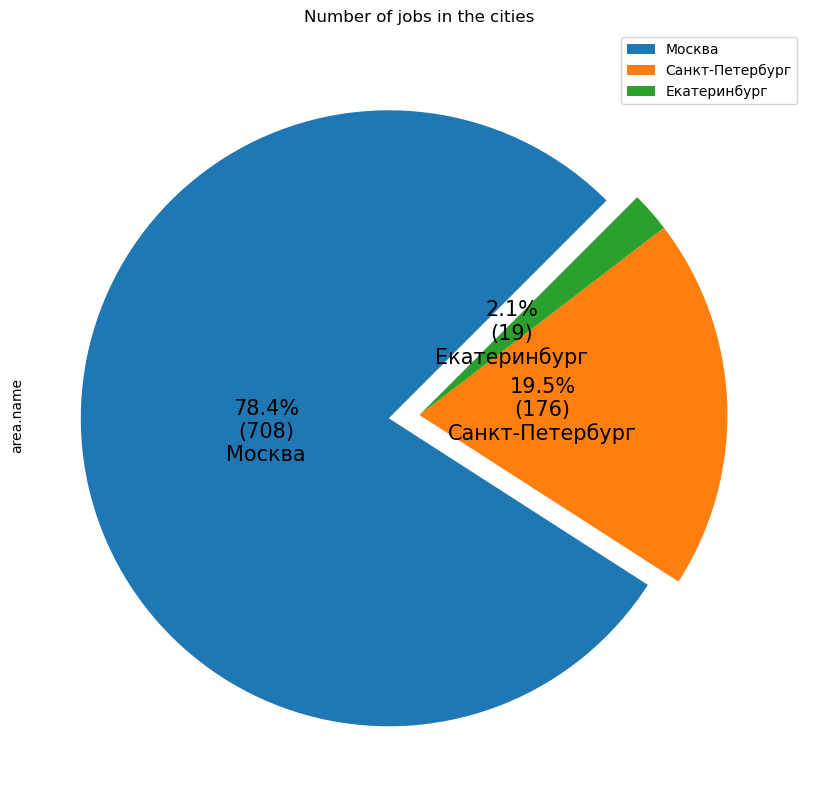

In [4]:
def my_autopct_with_absolute(pct, data: pd.Series):
    absolute = int(round(pct/100.*sum(data)))
    for i in range(len(data)):
        if data[i] == absolute:
            name = data.index[i]
            break
    
    return "{:.1f}%\n({:d})\n{:s}".format(pct, absolute, name)
    
df["area.name"].value_counts().plot.pie(autopct=lambda pct: my_autopct_with_absolute(pct, df["area.name"].value_counts()),
                                        explode=[0.1 if i == 0 else 0 for i in range(len(df["area.name"].value_counts()))], 
                                        figsize=(10, 10), 
                                        labeldistance=None, 
                                        pctdistance=0.4, 
                                        textprops={'fontsize': 15}, 
                                        startangle=45, 
                                        title="Number of jobs in the cities", 
                                        legend=True);



## 5. Build a histogram by the salary.to field.
5.1 Add a field of the city and make the histogram stacked

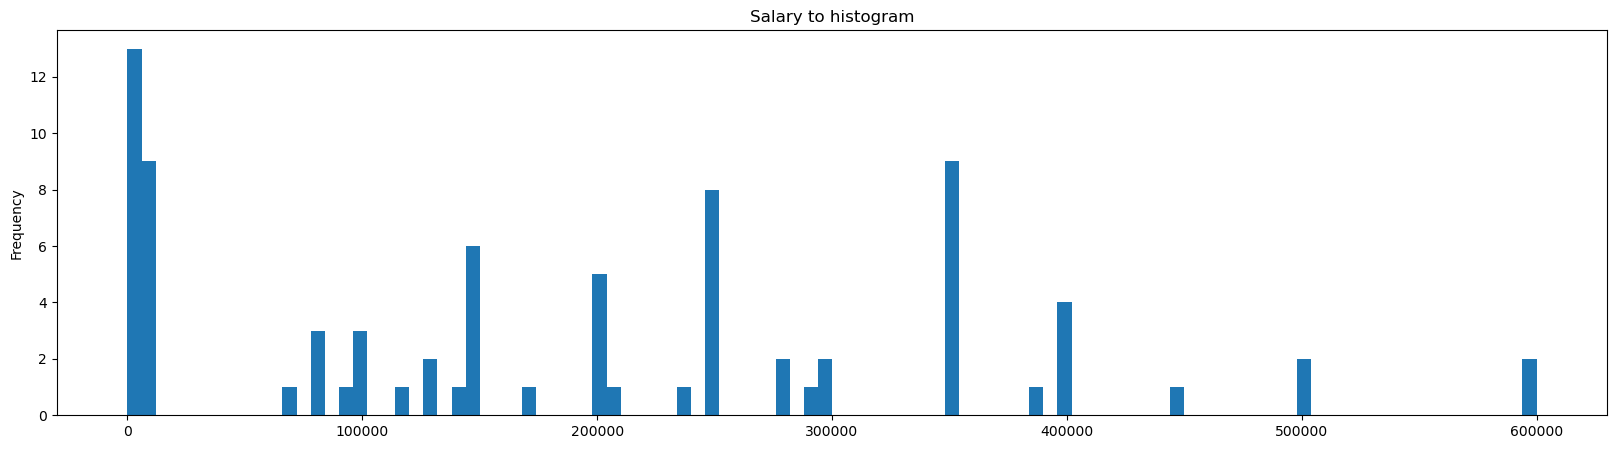

In [5]:
df["salary.to"].plot.hist(bins=100, figsize=(20, 5), title="Salary to histogram");

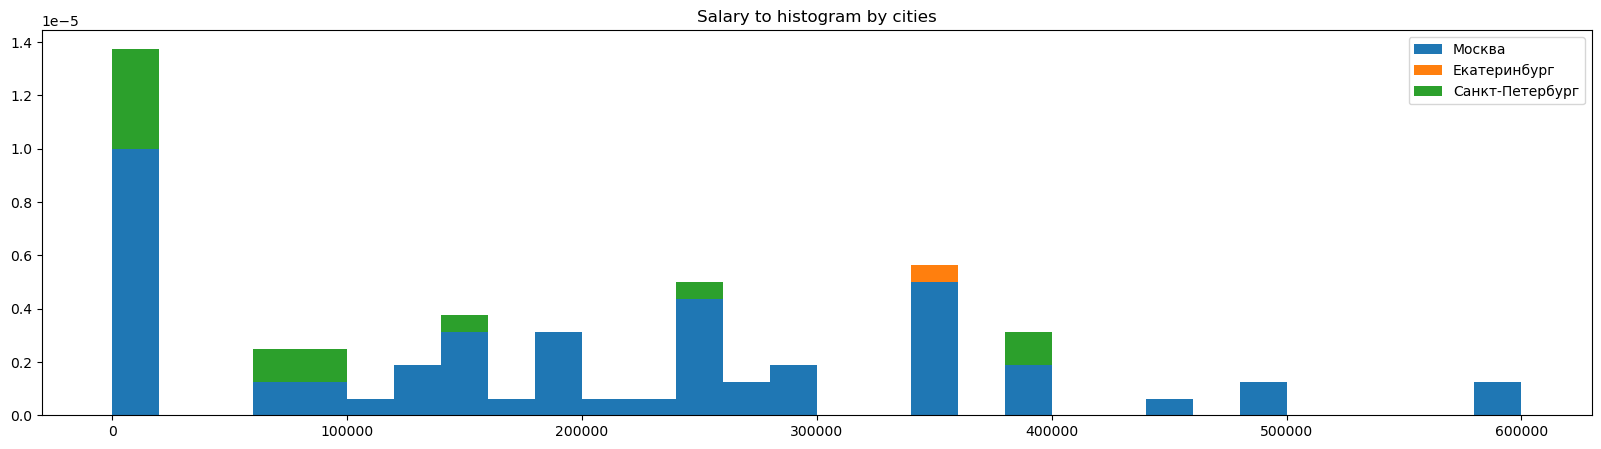

In [6]:
df_dict = {}
for unique_area in df["area.name"].unique():
    df_dict[unique_area] = df[df["area.name"] == unique_area]["salary.to"]
plt.figure(figsize=(20, 5))
plt.hist(df_dict.values(), bins=30, label=list(df_dict.keys()), histtype='barstacked', density=True)
plt.legend()
plt.title("Salary to histogram by cities");

## 6. Build a heat map of the average salary by salary.to field in terms of - work schedule and city.

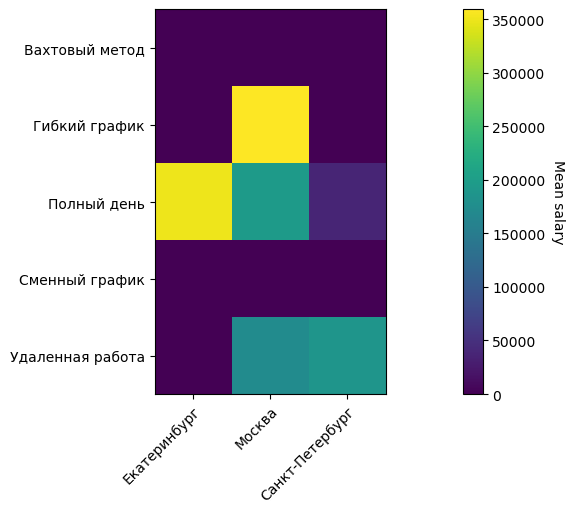

In [7]:
# Build a heat map of the average salary by salary.to field in terms of - work schedule and city.

task6_df = df[['salary.to', 'schedule.name', 'area.name']].groupby(['schedule.name', 'area.name']).mean().unstack().fillna(0)

data = task6_df.values
y_labels = task6_df.index
x_labels = task6_df.columns.get_level_values(1)

fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow(data)

ax.set_xticks(range(len(x_labels)), labels=x_labels)
ax.set_yticks(range(len(y_labels)), labels=y_labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Mean salary", rotation=-90, va="bottom")
plt.show();

## 7. Build a box chart by the field salary.from in the context of the city. 

7.1. Add a colour for the city inside the diagram

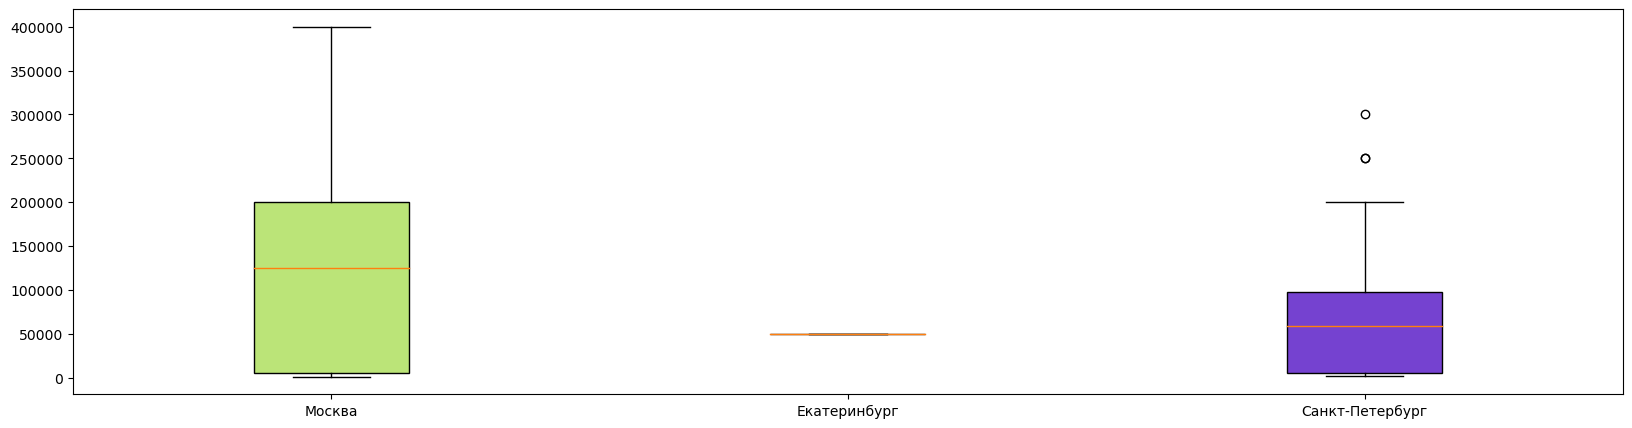

In [12]:
def random_color_generator():
    while True:
        yield '#%06X' % random.randint(0, 0xFFFFFF)
        
color = random_color_generator()

df_dict = {}
for unique_area in df["area.name"].unique():
    df_dict[unique_area] = df[df["area.name"] == unique_area]["salary.from"].dropna()
fig, ax = plt.subplots(figsize=(20, 5))
box = ax.boxplot(df_dict.values(), labels=list(df_dict.keys()), patch_artist=True)
for patch, color in zip(box['boxes'], color):
    patch.set_facecolor(color)


## 8. Build a doughnut diagram by frequency of technologies - systems, frameworks, libraries (extract from candidate requirements using string functions or regular expression module - re)

In [13]:
# list of technologies - systems, frameworks, libraries
technologies = ['python', 'java', 'javascript', 'c', 'c++', 'c#', 'php', 'sql', 'html', 'css', 'ruby', 'swift', 'scala', 'go', 'kotlin', 'typescript', 'bash', 'powershell', 'r', 'matlab', 'perl', 'groovy', 'lua', 'delphi', 'assembly', 'fortran', 'cobol', 'lisp', 'erlang', 'haskell', 'prolog', 'clojure', 'rust', 'dart', 'f#', 'pascal', 'visualbasic']
# add to this list big data technologies
technologies.extend([ 'hadoop', 'spark', 'hive', 'pig', 'mapreduce', 'flume', 'sqoop', 'oozie', 'zookeeper', 'kafka', 'storm', 'flink', 'elasticsearch', 'kibana', 'logstash', 'splunk', 'cassandra', 'hbase', 'mongodb', 'redis', 'memcached', 'neo4j', 'orientdb', 'postgresql', 'mysql', 'oracle', 'sqlserver', 'db2', 'sqlite', 'nosql', 'etl', 'datawarehouse', 'datawarehouse', 'datawarehouse'])
# add to this list machine learning technologies
technologies.extend([ 'tensorflow', 'keras', 'pytorch', 'caffe', 'scikit-learn', 'scipy', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'bokeh'])
# add to this list web technologies
technologies.extend([ 'django', 'flask', 'spring', 'springboot', 'springmvc', 'springdata', 'springsecurity', 'springcloud', 'springintegration', 'springbatch', 'springjms', 'springamqp', 'springwebflow', 'springwebsocket', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdatamongodb', 'springdataneo4j', 'springdataredis', 'springdatacassandra', 'springdatajpa', 'springdatarest', 'springdatajpa', 'springdataelasticsearch', 'springdat'])
# add to this list mobile technologies
technologies.extend([ 'android', 'ios', 'reactnative', 'xamarin', 'flutter'])
# add to this list mathematical skills
technologies.extend([ 'linearalgebra', 'calculus', 'statistics', 'probability', 'optimization', 'algorithms', 'datastructures', 'complexitytheory', 'graphtheory', 'discreteoptimization', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus', 'numericalprobability', 'numericalstatistics', 'numericalanalysis', 'numericalmethods', 'numericaloptimization', 'numericallinearalgebra', 'numericalcalculus'])
# add to this list cloud technologies
technologies.extend([ 'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'openshift'])
# add to this list devops technologies
technologies.extend([ 'jenkins', 'git', 'github', 'gitlab', 'bitbucket', 'svn', 'maven', 'gradle', 'ant', 'jira', 'confluence', 'bamboo', 'nexus', 'sonarqube', 'selenium', 'jmeter'])
# add to this list other technologies
technologies.extend([ 'linux', 'unix', 'windows', 'macos', 'networking', 'security', 'virtualization', 'cloudcomputing', 'blockchain', 'artificialintelligence', 'machinelearning', 'deeplearning', 'naturallanguageprocessing', 'computergraphics', 'computervision', 'robotics', 'cybersecurity', 'bigdata', 'iot', 'embedded', 'embeddedlinux', 'embeddedc', 'embeddedc++', 'embeddedjava', 'embeddedpython', 'embeddedruby', 'embeddedjavascript', 'embeddedtypescript', 'embeddedgo', 'embeddedkotlin', 'embeddedscala', 'embeddedrust', 'embeddeddart', 'embeddedf#', 'embeddedpascal', 'embeddedvisualbasic', 'embeddedassembly', 'embeddedfortran', 'embeddedcobol', 'embeddedlisp', 'embeddederlang', 'embeddedhaskell', 'embeddedprolog', 'embeddedclojure', 'embeddedlua', 'embeddeddelphi', 'embeddedbash', 'embeddedpowershell', 'embeddedr', 'embeddedmatlab', 'embeddedperl', 'embeddedgroovy', 'embeddedhtml', 'embeddedcss', 'embeddedc#', 'embeddedphp', 'embeddedsql', 'embeddedhadoop', 'embeddedspark', 'embeddedhive', 'embeddedpig', 'embeddedmapreduce', 'embeddedflume', 'embeddedsqoop', 'embeddedoozie', 'embeddedzookeeper', 'embeddedkafka', 'embeddedstorm', 'embeddedflink', 'embeddedelasticsearch', 'embeddedkibana', 'embeddedlogstash', 'embeddedsplunk', 'embeddedcassandra', 'embeddedhbase', 'embeddedmongodb', 'embeddedredis', 'embeddedmemcached', 'embeddedneo4j', 'embeddedorientdb', 'embeddedpostgresql', 'embeddedmysql', 'embeddedoracle', 'embeddedsqlserver', 'embeddeddb2', 'embeddedsqlite', 'embeddednosql', 'embeddedetl', 'embeddeddatawarehouse', 'embeddeddatawarehouse', 'embeddeddatawarehouse', 'embeddedtensorflow', 'embeddedkeras', 'embeddedpytorch', 'embeddedcaffe', 'embeddedscikit-learn', 'embeddedscipy', 'embeddednumpy', 'embeddedpandas', 'embeddedmatplotlib', 'embeddedseaborn', 'embeddedbokeh', 'embeddedandroid', 'embeddedios', 'embeddedreactnative', 'embeddedxamarin', 'embeddedflutter', 'embeddedlinearalgebra', 'embedded'])
technologies = list(set(technologies))

In [14]:
# extract technologies - systems, frameworks, libraries from candidate requirements using string functions or regular expressions

words_count = df["snippet.requirement"].str.lower().str.split().explode().value_counts()
# extract technologies - systems, frameworks, libraries from words_count
# filter all russian prepositions, conjunctions, etc. with nltk
filtered_words = words_count[~words_count.index.isin(stopwords.words('russian'))]
# delete symbols from words but remain words use re
filtered_words.index = filtered_words.index.str.replace(r'[^\w\s]+', '', regex=True)
# fillter all english stop words with nltk
filtered_words = filtered_words[~filtered_words.index.isin(stopwords.words('english'))]

In [15]:
print(len(filtered_words))
print(len(set(filtered_words.index)))

4329
3185


In [16]:
# sum equal words in filtered_words
filtered_words = filtered_words.groupby(filtered_words.index).sum()
filtered_words = filtered_words.sort_values(ascending=False)

In [17]:
# translate words to english

def translate_word(word):
    # check if word is russian with re
    if word.isalpha() and re.match(r'[а-яА-Я]+', word):
        # translate word to english
        translated_word = translator.translate(word)
        return translated_word
    else:
        return word

reuslt_words = []
for word in tqdm(filtered_words.index):
    reuslt_words.append(translate_word(word))

  0%|          | 0/3185 [00:00<?, ?it/s]

In [18]:
filtered_words = filtered_words.set_axis(reuslt_words)
print(len(filtered_words))
filtered_words = filtered_words.groupby(filtered_words.index).sum()
filtered_words = filtered_words.sort_values(ascending=False)
print(len(filtered_words))

3185
2282


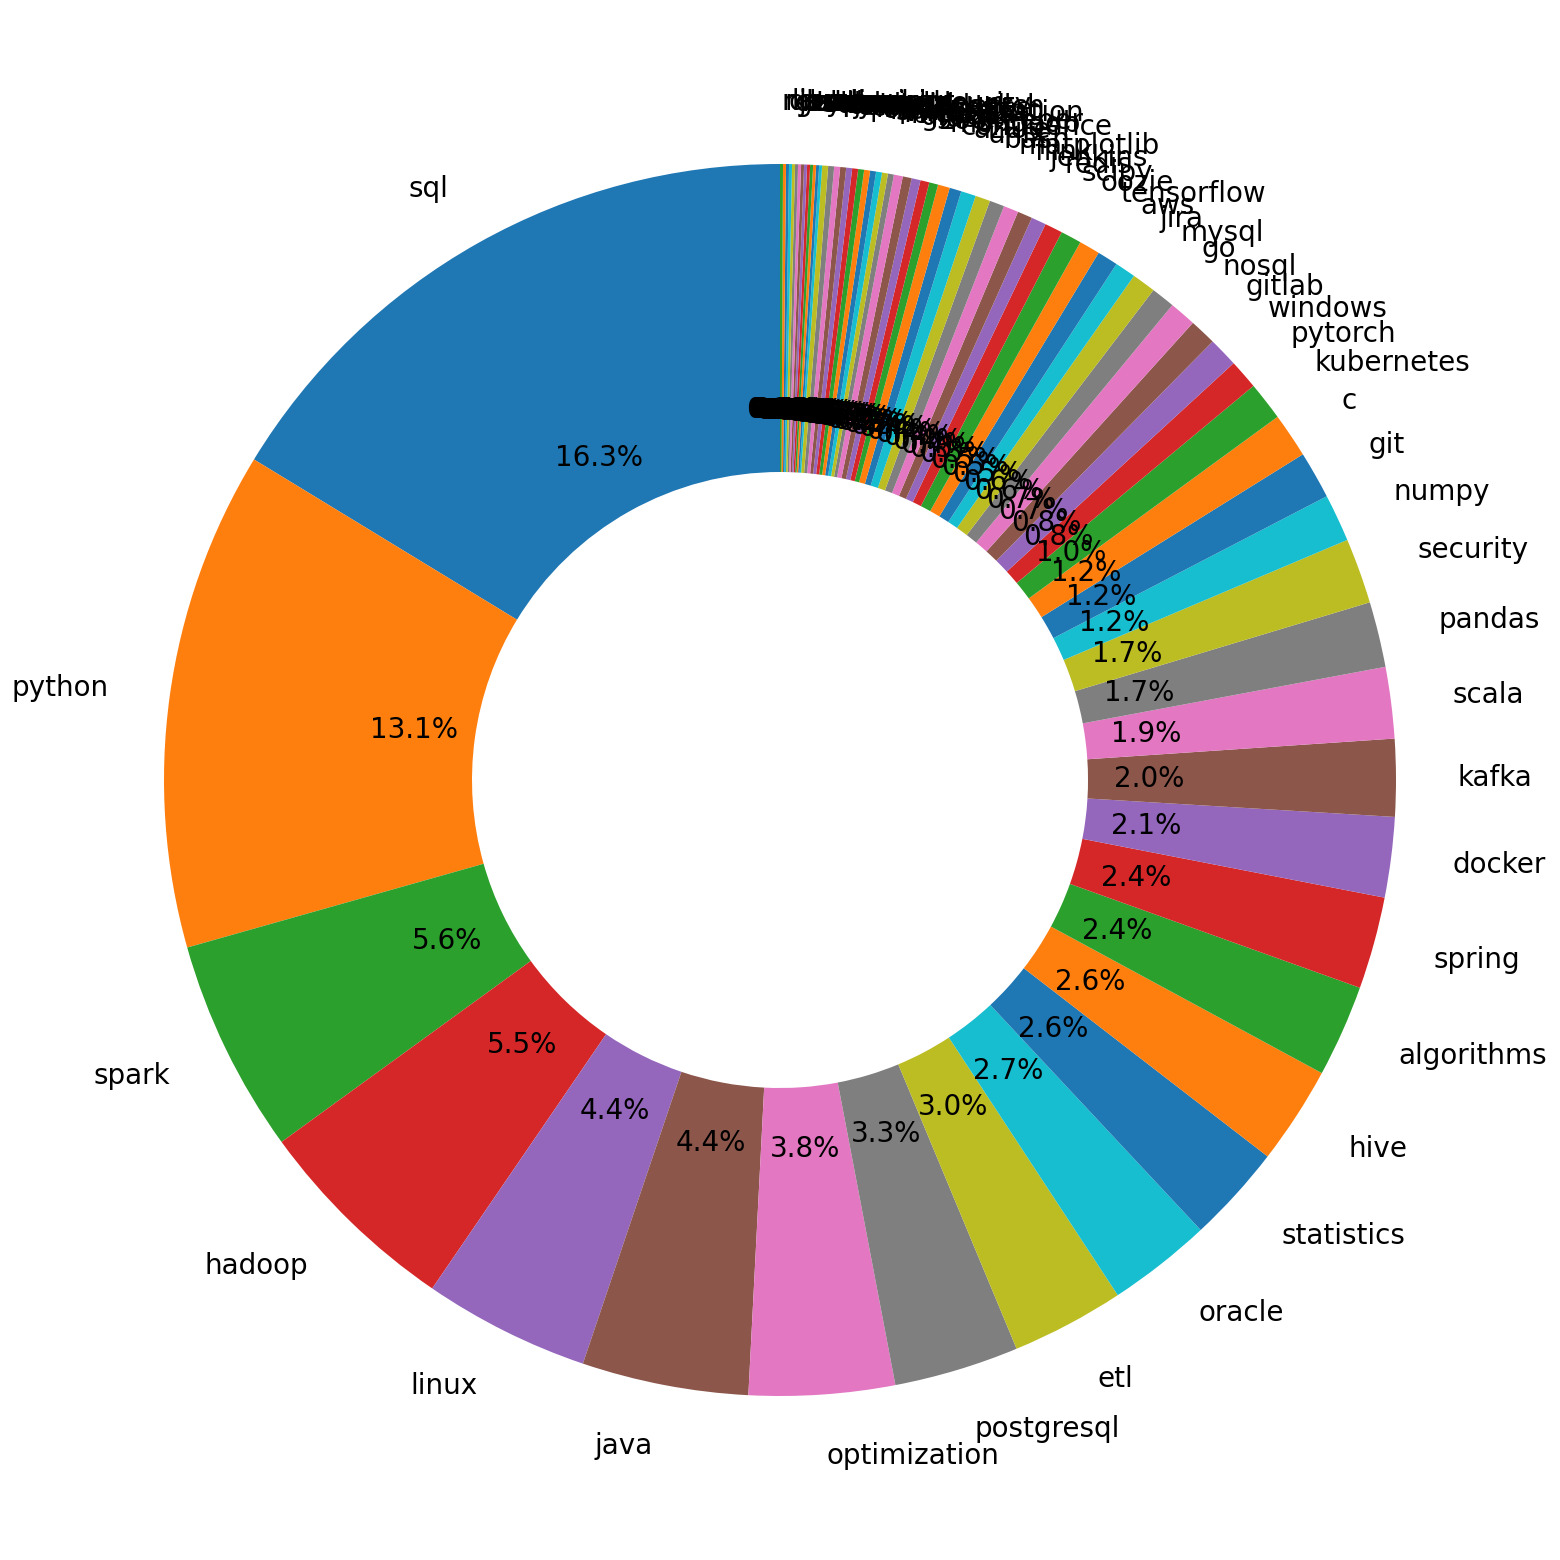

In [19]:
# filter all words that are not in technologies list
filtered_words = filtered_words[filtered_words.index.isin(technologies)]

plt.figure(figsize=(20, 20))
plt.pie(filtered_words, labels=filtered_words.index, autopct='%1.1f%%', 
        wedgeprops=dict(width=0.5), 
        startangle=90, textprops={'fontsize': 20});


## 9. Build a scatter diagram - number of years of experience (select from candidate requirements using string functions or regular expression module - re) - salary (field salary.from)
9.1 Add a grid

9.2 Colour the dots with the colour of the city

9.3. add point size - number of vacancies per point coordinates

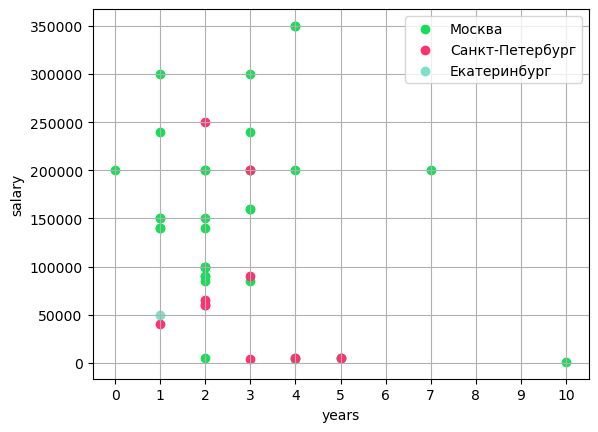

In [29]:
# find numbers in candidate requirements
task9_df = pd.DataFrame()
task9_df["years"] = df["snippet.requirement"].str.lower().str.findall(r'\d+').explode()
task9_df["city"] = df["area.name"]
task9_df.dropna(inplace=True)
task9_df["years"] = task9_df["years"].astype(int)
task9_df["salary"] = df["salary.from"]
task9_df.dropna(inplace=True)
task9_df.drop(task9_df[task9_df["years"] > 50].index, inplace=True)
for c, city in zip(random_color_generator(), task9_df["city"].unique()):
    plt.scatter(task9_df[task9_df["city"] == city]["years"], task9_df[task9_df["city"] == city]["salary"], c=c, label=city)
plt.grid()
# set xticks with step 1 without numpy
plt.xlabel("years")
plt.ylabel("salary")
plt.xticks(range(0, max(task9_df.years)+1, 1))
plt.legend()
plt.show();

## 10. Plot a horizontal bar chart describing the contribution of each factor to wages if the factors are understood to be city and work schedule.
Use linear regression analysis.

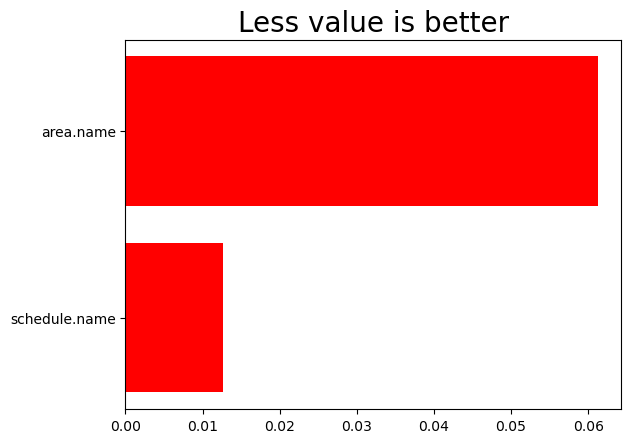

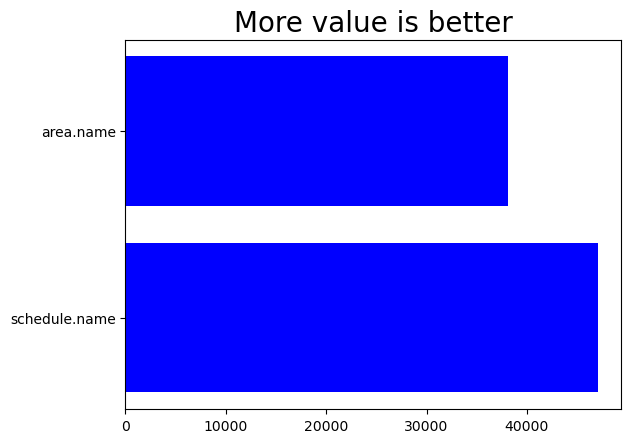

In [33]:
from statsmodels import api as sm
from sklearn.preprocessing import LabelEncoder
task10_df = df[["salary.from", "schedule.name", "area.name"]].copy(deep=True)
# drop rows with NaN values
task10_df.dropna(inplace=True)
# encode categorical features with label encoder
# task10_df = pd.get_dummies(task10_df, columns=["schedule.name", "area.name"])
task10_df["schedule.name"] = LabelEncoder().fit_transform(task10_df["schedule.name"])
task10_df["area.name"] = LabelEncoder().fit_transform(task10_df["area.name"])
# fit ols model
ols = sm.OLS(task10_df["salary.from"], task10_df.drop("salary.from", axis=1))
data1 = ols.fit().pvalues
data2 = abs(ols.fit().params)
# plot horizontal bar chart
plt.barh(data1.index, data1.values, color="red")
plt.title("Less value is better", fontsize=20)
plt.show();
plt.barh(data2.index, data2.values, color="blue")
plt.title("More value is better", fontsize=20)
plt.show();